In [1]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\sphere\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

In [2]:
%load_ext autoreload
%autoreload 2

# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

### Analytic solution for linear acoustic wavefield generated by oscillating sphere

Dots in middle panel: numerical differentiation of psi
Dots in bottom panel: numerical differentiation of dpsi


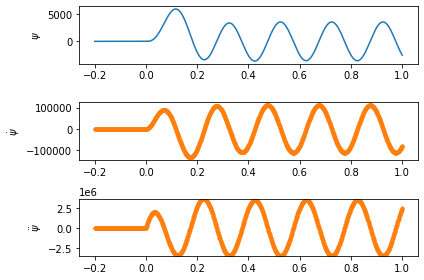

In [743]:
# Mode: prod | test
# prod for comparing results to a relevant test case
# test for a test problem with distinct transient and harmonic behaviours
mode:str = "prod"

if mode == 'test':
  # Background density
  rho = 1.2
  # Sound speed
  c = 343
  # Sphere radius
  a = 0.01
  # Sphere oscillation amplitude
  u0 = 1
  # Sphere oscillation frequency
  w = 100
else:
  # Background density
  rho = 1e5 / (287 * 300)
  # Sound speed
  c = np.sqrt(1.4 * 287 * 300)
  # Sphere radius
  a = 30
  # Sphere oscillation amplitude
  u0 = 1
  # Sphere oscillation angular frequency
  w = 5 * (2 * np.pi)

# Natural frequency of ODE. Note: this is a linear frequency
fn = c / a
prefactor = fn * fn * a*a*a * u0
def psi(t):
  t = np.clip(t, 0, None)
  numerator = (w**3 * np.exp(-fn * t) * np.sin(fn * t)
              - w**2 * fn * np.sin(w * t)
              + 2 * fn**3 * np.sin(w * t)
              - 2 * w * fn**2 * np.cos(w * t)
              + 2 * w * fn**2 * np.exp(-fn * t) * np.cos(fn * t))
  denom = w**5 * fn + 4 * w * fn**5
  return np.where(t > 0,
                  prefactor * w * (numerator / denom),
                  0)

def dpsi(t):
  t = np.clip(t, 0, None)
  numerator = (w**3 * fn * (-np.exp(-fn * t) * np.sin(fn * t) + np.exp(-fn * t) * np.cos(fn * t))
              - w**3 * fn * np.cos(w * t)
              + 2 * w * fn**3 * np.cos(w * t)
              + 2 * w**2 * fn**2 * np.sin(w * t)
              + 2 * w * fn**3 * (-np.exp(-fn * t) * np.cos(fn * t) - np.exp(-fn * t) * np.sin(fn * t)))
  denom = w**5 * fn + 4 * w * fn**5
  return np.where(t > 0,
                  prefactor * w * (numerator / denom),
                  0)

def RHS(t):
  return np.where(t > 0,
                  c * c * a * u0 * np.sin(w*t),
                  0)

def ddpsi(t):
  return RHS(t) - 2 * fn * dpsi(t) - 2 * fn * fn * psi(t)

t_range = np.linspace(-1, 5, 1200) * 2 * np.pi / w
dt = t_range[1] - t_range[0]
t_range_mean = 0.5 * (t_range[1:] + t_range[:-1])
fig, ax = plt.subplots(3,1)

ax[0].plot(t_range, psi(t_range))
ax[0].set_ylabel(r"$\psi$")
ax[1].plot(t_range, dpsi(t_range))
ax[1].plot(t_range_mean, np.diff(psi(t_range))/ dt, '.')
ax[1].set_ylabel(r"$\dot{\psi}$")
ax[2].plot(t_range, ddpsi(t_range))
ax[2].plot(t_range_mean, np.diff(dpsi(t_range))/ dt, '.')
ax[2].set_ylim(ddpsi(t_range).min(), ddpsi(t_range).max())
ax[2].set_ylabel(r"$\ddot{\psi}$")
plt.tight_layout()
print("Dots in middle panel: numerical differentiation of psi")
print("Dots in bottom panel: numerical differentiation of dpsi")

The potential function is associated with a transient (scale T_n), 
followed by the forced oscillation (T_omega).


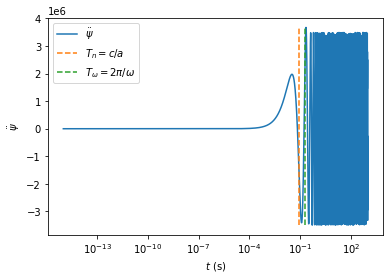

In [4]:
''' Plot ddpsi for transient and oscillation timescales '''

test_t_range = np.geomspace(1e-15,1e3,6000)
test_ddpsi_range = ddpsi(test_t_range)
plt.semilogx(test_t_range, test_ddpsi_range)
# Natural wave period of lengthscale a
Tn = 1 / fn
plt.plot(Tn * np.array([1, 1]), np.array([test_ddpsi_range.min(), test_ddpsi_range.max()]), '--')
plt.plot(2 * np.pi / w * np.array([1, 1]), np.array([test_ddpsi_range.min(), test_ddpsi_range.max()]), '--')
plt.gca().set_ylabel(r"$\ddot{\psi}$")
plt.xlabel("$t$ (s)")
plt.legend([r"$\ddot{\psi}$", r"$T_n = c / a$",r"$T_\omega = 2 \pi / \omega$"])
print("The potential function is associated with a transient (scale T_n), ")
print("followed by the forced oscillation (T_omega).")

In [5]:
wavelength = (2 * np.pi) * c / w

Left column: before wave arrival
Right column: after wave arrival
At fixed r = 100 = 1.4401389974026995 wavelengths.


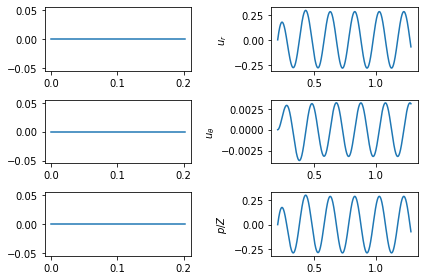

In [6]:
r = 100
theta = 0.1

t_range_noncausal = np.linspace(0, (r - a) / c, 1000)
t_range_causal = np.linspace((r - a) / c, 5 * (2 * np.pi) / w + r / c, 5000)

def field(r, theta, t) -> tuple:
  t_lag = t - (r-a)/c
  _psi = psi(t_lag)
  _dpsi = dpsi(t_lag)
  _ddpsi = ddpsi(t_lag)
  u_r = np.cos(theta) * (2 * _psi / (r*r*r) + _dpsi / (r*r*c) + _ddpsi / (r*c*c))
  u_th = -np.sin(theta) / r * (-_psi / (r*r) - _dpsi / (r*c))
  p = - rho * np.cos(theta) * (-_dpsi/(r * r) - _ddpsi/(r*c))
  return (p, u_r, u_th)

p, u_r, u_th = field(r, theta, t_range_noncausal)
plt.subplot(3,2,1)
plt.plot(t_range_noncausal, u_r)
plt.subplot(3,2,3)
plt.plot(t_range_noncausal, u_th)
plt.subplot(3,2,5)
plt.plot(t_range_noncausal, p)

p, u_r, u_th = field(r, theta, t_range_causal)
plt.subplot(3,2,2)
plt.plot(t_range_causal, u_r)
plt.ylabel("$u_r$")
plt.subplot(3,2,4)
plt.plot(t_range_causal, u_th)
plt.ylabel(r"$u_\theta$")
plt.subplot(3,2,6)
plt.plot(t_range_causal, p / (rho*c))
plt.ylabel("$p / Z$")

plt.tight_layout()
print("Left column: before wave arrival")
print("Right column: after wave arrival")
print(f"At fixed r = {r} = {r/(wavelength)} wavelengths.")

if mode == "test":
  print("Transient is underresolved. ")


In [7]:
if mode == "test":
  plt.plot(t_range_causal, -w * w * rho / c * (0.5 * a**3 * u0) * np.cos(theta) * np.sin(w*(t_range_causal - (r-a)/c)) / r)
  plt.plot(t_range_causal, p, '.-')
  plt.plot(t_range_causal, u_r * rho * c, '+-')
  # plt.xlim(left=0.295)
  plt.ylim(-.2e-6, .2e-6)
  plt.legend(["Linear approx, ka << 1", "Calculation p", "Calculation Z u_r"])
  print("Comparing calculated solution with steady approx for ka << 1.")
  print("Transient (solid line) is underresolved and clipped in the vertical axis.")

  plt.draw()
  
  plt.figure()
  x_range = np.linspace(-2, 2, 800) * wavelength
  y_range = np.linspace(-2, 2, 800) * wavelength
  mg_x, mg_y = np.meshgrid(x_range, y_range)
  r = np.sqrt(mg_x**2 + mg_y**2)
  theta = np.arctan2(mg_y, mg_x)

  t = 0.100
  p, u_r, u_theta = field(r, theta, t)

  plt.contourf(x_range, y_range, p * r * 1e6, levels=np.linspace(-50, 50, 100))

  plt.colorbar()
  plt.title(r"$p \cdot r$ ($\mu$Pa m)")
  print(f"t = {t} s")
  print(f"Wavelength: {wavelength} m")

  plt.figure()
  window_size = 100 * a
  x_range = np.linspace(-window_size, window_size, 800)
  y_range = np.linspace(-window_size, window_size, 800)
  mg_x, mg_y = np.meshgrid(x_range, y_range)
  r = np.sqrt(mg_x**2 + mg_y**2)
  theta = np.arctan2(mg_y, mg_x)

  t = 80/fn
  p, u_r, u_theta = field(r, theta, t)

  # Compute micro pascal meter, masking away data inside the sphere
  mg_z = np.where(r > a, p * r * 1e6, np.nan)
  # Mask out 
  plt.contourf(x_range, y_range, mg_z, levels=np.linspace(-8000, 8000, 300))
  plt.colorbar()
  plt.title(r"$p \cdot r$ ($\mu$Pa m)")

  # Plot sphere
  theta_range = np.linspace(0, 2*np.pi, 9900+1)[:-1]
  plt.plot(a * np.cos(theta_range), a * np.sin(theta_range), 'k-')

  print(f"t = {t} s")
  print(f"Transient pressure wave from initial acceleration. ")

t = 0.742857142857148 s
Wavelength: 69.43774189876858 m


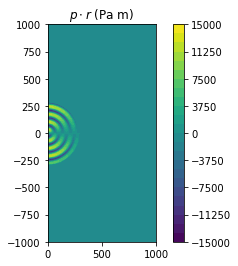

In [8]:
# Plot solution field (for mode 'prod')
if mode != "test":
  x_range = np.linspace(0, 1000, 800)
  y_range = np.linspace(-1000, 1000, 800)
  mg_x, mg_y = np.meshgrid(x_range, y_range)
  r = np.sqrt(mg_x**2 + mg_y**2)
  theta = np.arctan2(mg_y, mg_x) + np.pi/2 # Rotate to +y initial movement

  # t = 1000 / 343
  t = 0.742857142857148

  p, u_r, u_theta = field(r, theta, t)

  plt.contourf(x_range, y_range, p * r, levels=np.linspace(-15e3, 15e3, 25))

  plt.colorbar()
  plt.title(r"$p \cdot r$ (Pa m)")
  print(f"t = {t} s")
  print(f"Wavelength: {wavelength} m")
  plt.gca().set_aspect('equal')

### Read unsteady flow domain data

In [9]:
solver_from = lambda file_idx: readwritedatafiles.read_data_file(
  f"sphere_4_{file_idx}.pkl")

t = 2.3749999999999605 s
Wavelength: 69.43774189876858 m


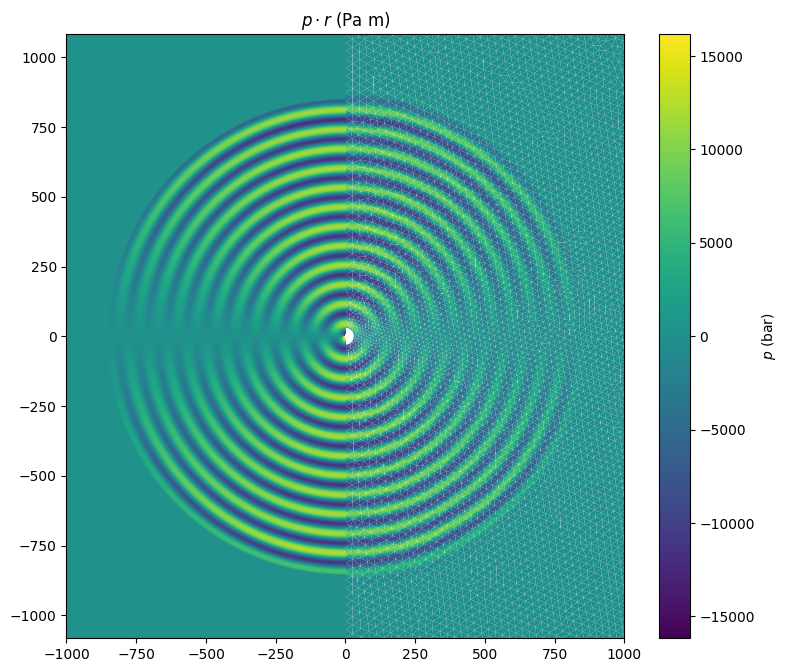

In [10]:
%matplotlib inline
solver = solver_from(95)

quantity = lambda U: solver.physics.compute_variable(
  "Pressure", U) - 1e5
colorbar_label = "$p$ (bar)"
cmap = matplotlib.cm.viridis

coordinate_scaling = lambda x: np.linalg.norm(x, axis=-1, keepdims=True)

fig, ax = plt.subplots(figsize=(9,8), dpi=100)
clims = (-16167, 16167)
x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]

r_window = 1200
(_, cb) = processing.mdtools.plot_detailed(x_tri, solver.state_coeffs, quantity, clims, 2,
  colorbar_label=colorbar_label,
  xview=(0,r_window),
  yview=(-r_window,r_window),
  n_samples=16,
  cmap=cmap,
  coordinate_scaling=coordinate_scaling)

# Plot analytic solution
square_edge = 1200
x_range = np.linspace(-square_edge, 0, 1600)
y_range = np.linspace(-square_edge, square_edge, 1600)
mg_x, mg_y = np.meshgrid(x_range, y_range)
r = np.sqrt(mg_x**2 + mg_y**2)
theta = np.arctan2(mg_y, mg_x) + np.pi/2 # Rotate to +y initial movement

p, u_r, u_theta = field(r, theta, solver.time)

plt.contourf(x_range, y_range, p * r, levels=np.linspace(*clims, 100))

# plt.colorbar()

plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.title(r"$p \cdot r$ (Pa m)")
print(f"t = {solver.time} s")
print(f"Wavelength: {wavelength} m")
plt.gca().set_aspect('equal')

t = 2.3749999999999605 s
Wavelength: 69.43774189876858 m


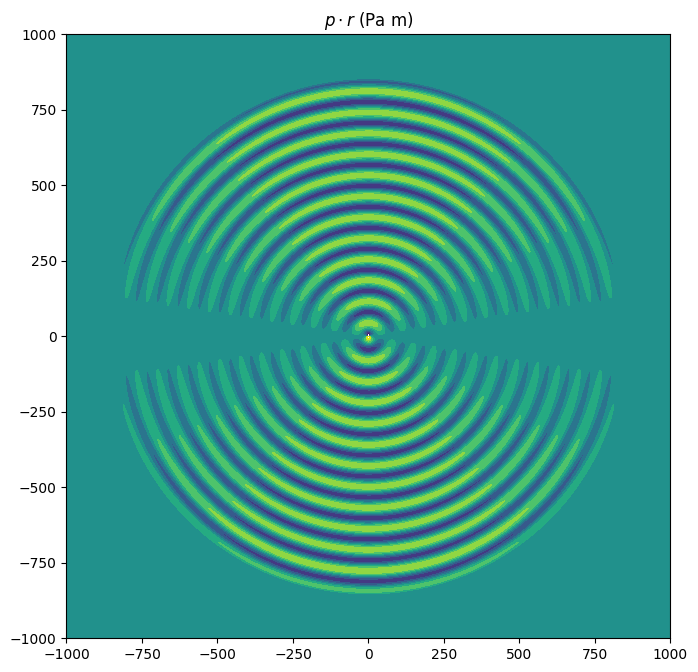

In [11]:
fig, ax = plt.subplots(figsize=(9,8), dpi=100)

plt.contourf(x_range, y_range, p * r, levels=np.linspace(*clims, 10))
plt.contourf(-x_range, y_range, p * r, levels=np.linspace(*clims, 10))
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.title(r"$p \cdot r$ (Pa m)")
print(f"t = {solver.time} s")
print(f"Wavelength: {wavelength} m")
plt.gca().set_aspect('equal')

### Using compressed output (npz)

In [744]:
npz_load = lambda i: np.load(f"sphere_5_{i}.npz")
solver_from = lambda file_idx: readwritedatafiles.read_data_file(
  f"sphere_5_{file_idx}.pkl")
num_files = 1440

def compute_history(x_in:np.array):
  # Initialize
  solver = solver_from(0)
  x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
  ref_mapping = mdtools.compute_ref_mapping(x_tri)
  # Compute global reference coordinates for x_in point
  ref_coords_global = np.einsum("kij, kj -> ki", ref_mapping, x_in - x_tri[:,0,:])
  # Boolean mask for whether barycentric coordinates in triangle
  in_triangle = ((ref_coords_global[...,0] >= 0)
                & (ref_coords_global[...,1] >= 0 )
                & (ref_coords_global[...,0] + ref_coords_global[...,1] <= 1))
  # Element id of located triangle
  elt_id = int(np.array(np.where(in_triangle)))

  vec_t = np.zeros((num_files,))
  vec_p = np.zeros_like(vec_t)
  vec_u = np.zeros_like(vec_t)
  vec_v = np.zeros_like(vec_t)
  vec_s = np.zeros_like(vec_t)
  vec_T = np.zeros_like(vec_t)
  vec_Z = np.zeros_like(vec_t)

  for i in range(0, num_files):
    if i == 0:
      solver0 = solver_from(0)
      U = solver0.state_coeffs
      t = solver0.time
    else:
      step_dat:dict = npz_load(i)
      U = step_dat["state_coeffs"]
      t = step_dat["time"]

    # Evaluate U at point
    U_point = mdtools.eval_state_at(U[elt_id,:,:],
                                    ref_coords_global[elt_id,:], 2)
    # Evaluate quantity at point
    p = solver.physics.compute_variable(
      "Pressure", np.reshape(U_point, (1,-1,9)))
    vec_p[i] = p - 1e5
    vec_u[i] = solver.physics.compute_variable(
      "XVelocity", np.reshape(U_point, (1,-1,9)))
    vec_v[i] = solver.physics.compute_variable(
      "YVelocity", np.reshape(U_point, (1,-1,9)))
    T = solver.physics.compute_variable(
      "Temperature", np.reshape(U_point, (1,-1,9)))
    Gamma = solver.physics.compute_variable(
      "Gamma", np.reshape(U_point, (1,-1,9)))
    vec_T[i] = T
    vec_s[i] = T ** (Gamma) / p ** (Gamma-1)
    vec_t[i] = t

    c = solver.physics.compute_variable(
      "SoundSpeed", np.reshape(U_point, (1,-1,9)))
    rho = U_point[...,0:3].sum(axis=-1, keepdims=True)
    vec_Z[i] = rho * c
  
  return vec_t, vec_p, vec_u, vec_v, vec_T, vec_s, vec_Z

In [745]:
x_in = 5 * wavelength * np.array([np.cos(np.pi/4), np.sin(np.pi/4)])
vec_t, vec_p, vec_u, vec_v, vec_T, vec_s, vec_Z = compute_history(x_in)

In [746]:
# Resolve velocity components from numerical
theta_actual = np.arctan2(x_in[1], x_in[0])
u_vec = np.stack((vec_u, vec_v), axis=-1)
n_hat = x_in/np.linalg.norm(x_in)
u_r = np.einsum("ki, i -> k", u_vec, n_hat)[...,np.newaxis]
# Tangential velocity vector
u_t_vec = u_vec - (u_r * n_hat)
# Tangential unit vector in the positive angle direction
t_hat = np.einsum("ij, j -> i", np.array([[0, -1],[1, 0]]), n_hat)
# Compute u_theta
u_theta = np.einsum("ij, j -> i", u_t_vec, t_hat)

# Plot analytic solution
r = np.linalg.norm(x_in)
theta_rotated = np.arctan2(x_in[1], x_in[0]) + np.pi/2 # Rotate to +y initial movement
vec_t_high_sample = np.linspace(vec_t[0], vec_t[-1], 5*vec_t.size)
p_analytical, u_r_analytical, u_theta_analytical = field(r, theta_rotated, vec_t_high_sample)

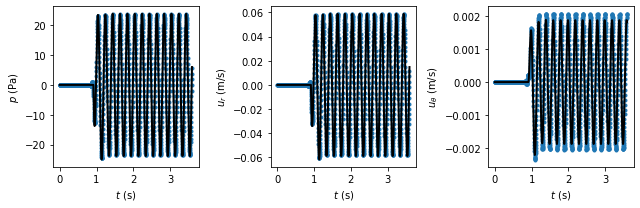

In [747]:
# Plot at fixed location only
fig, ax= plt.subplots(1, 3, figsize=(9,3))

ax[0].plot(vec_t, vec_p, '.')
ax[0].plot(vec_t_high_sample, p_analytical, 'k', linewidth=2)
ax[0].set_ylabel("$p$ (Pa)")

ax[1].plot(vec_t, u_r, '.')
ax[1].plot(vec_t_high_sample, u_r_analytical, 'k', linewidth=2)
ax[1].set_ylabel("$u_r$ (m/s)")

ax[2].plot(vec_t, u_theta, '.')
ax[2].plot(vec_t_high_sample, u_theta_analytical, 'k', linewidth=2)
ax[2].set_ylabel(r"$u_\theta$ (m/s)")

for i in range(3):
  ax[i].set_xlabel("$t$ (s)")
fig.tight_layout()

t = 3.5999999999999344 s
Wavelength: 69.43774189876858 m
Intended negative-z first motion. 


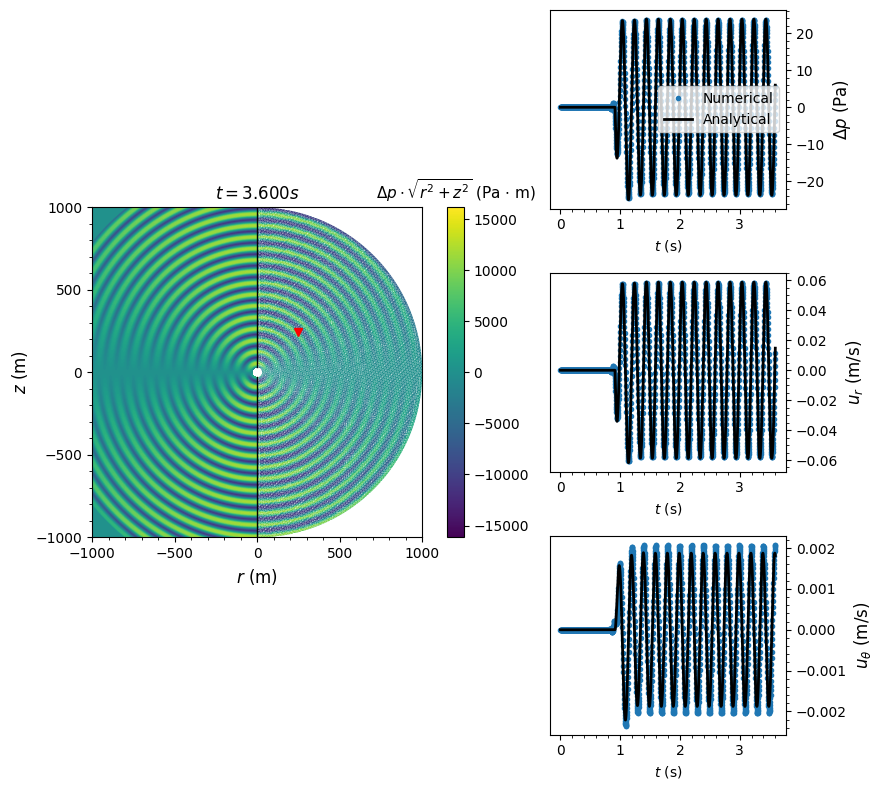

In [748]:
%matplotlib inline

fig = plt.figure(figsize=(9,8), dpi=100)
gs = fig.add_gridspec(12,3)
ax1 = fig.add_subplot(gs[3:9, 0:2])
ax2 = fig.add_subplot(gs[0:4, 2])
ax3 = fig.add_subplot(gs[4:8, 2])
ax4 = fig.add_subplot(gs[8:12, 2])
global_fontsize = 12

# Set load origin
npz_load = lambda i: np.load(f"sphere_5_{i}.npz")
solver_from = lambda file_idx: readwritedatafiles.read_data_file(
  f"sphere_5_{file_idx}.pkl")
contour_plot_file_index = 1440

# Set contour plot parameters
solver = solver_from(0)
quantity = lambda U: solver.physics.compute_variable("Pressure", U) - 1e5
colorbar_label = "$\Delta p \cdot \sqrt{r^2 + z^2}$ (Pa $\cdot$ m)"
cmap = matplotlib.cm.viridis
# Set coordinate scaling to apply to plot values
coordinate_scaling = lambda x: np.linalg.norm(x, axis=-1, keepdims=True)

clims = (-16167, 16167)
x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
r_window = 1200

# Plot numeric solution field
fig.sca(ax1)
frame_data = npz_load(contour_plot_file_index)
(_, cb) = processing.mdtools.plot_detailed(x_tri, frame_data["state_coeffs"],
  quantity, clims, 2,
  colorbar_label="",
  xview=(0,r_window),
  yview=(-r_window,r_window),
  n_samples=16,
  cmap=cmap,
  coordinate_scaling=coordinate_scaling)
cb.ax.set_title(colorbar_label, size=11)

# Compute analytic solution field
x_range = np.linspace(-r_window, 0, 1600)
y_range = np.linspace(-r_window, r_window, 1600)
mg_x, mg_y = np.meshgrid(x_range, y_range)
r = np.sqrt(mg_x**2 + mg_y**2)
theta = np.arctan2(mg_y, mg_x) + np.pi/2 # Rotate to +y initial movement
p_analytic_field, _, _ = field(r, theta, frame_data["time"])

print(f"t = {frame_data['time']} s")
print(f"Wavelength: {wavelength} m")
print(f"Intended negative-z first motion. ")

p_analytic_field_show = np.where(r >= a, p_analytic_field, np.nan)
ax1.contourf(x_range, y_range, p_analytic_field_show * r, levels=np.linspace(*clims, 100))
ax1.set_xlim(-1000, 1000)
ax1.set_ylim(-1000, 1000)
ax1.plot([0, 0], [a, 1000], 'k', linewidth=1)
ax1.plot([0, 0], [-1000, -a], 'k', linewidth=1)
ax1.set_title(rf"$t = {frame_data['time']:.3f} s$")
ax1.set_aspect("equal", "box")
ax1.minorticks_on()
ax1.set_xlabel("$r$ (m)", fontsize=global_fontsize)
ax1.set_ylabel("$z$ (m)", fontsize=global_fontsize)
ax1.xaxis.set_ticks(np.arange(-1000, 1000+1, 500))
ax1.yaxis.set_ticks(np.arange(-1000, 1000+1, 500))
ax1.plot(x_in[0], x_in[1], 'vr')

# Side panel axes
sp_axes = [ax2, ax3, ax4]

sp_axes[0].plot(vec_t, vec_p, '.')
sp_axes[0].plot(vec_t_high_sample, p_analytical, 'k', linewidth=2)
sp_axes[0].set_ylabel(r"$\Delta p$ (Pa)", fontsize=global_fontsize)

sp_axes[1].plot(vec_t, u_r, '.')
sp_axes[1].plot(vec_t_high_sample, u_r_analytical, 'k', linewidth=2)
sp_axes[1].set_ylabel("$u_r$ (m/s)", fontsize=global_fontsize)

sp_axes[2].plot(vec_t, u_theta, '.')
sp_axes[2].plot(vec_t_high_sample, u_theta_analytical, 'k', linewidth=2)
sp_axes[2].set_ylabel(r"$u_\theta$ (m/s)", fontsize=global_fontsize)

for i in range(3):
  sp_axes[i].set_xlabel("$t$ (s)")
  sp_axes[i].yaxis.set_label_position("right")
  sp_axes[i].yaxis.tick_right()
  sp_axes[i].minorticks_on()

sp_axes[0].legend(["Numerical", "Analytical"], loc="right")

fig.tight_layout()
plt.savefig("compound_sphere_plot_annotate.svg")
plt.savefig("compound_sphere_plot_annotate.png", format="png", dpi=400)

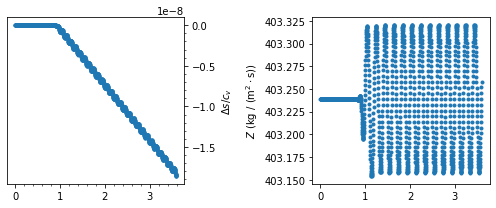

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))
ds = np.log(vec_s) - np.log(vec_s[0])
ax[0].plot(vec_t, ds, '.')
ax[0].set_ylabel("$\Delta s / c_v$")
ax[0].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()
ax[0].minorticks_on()

ax[1].plot(vec_t, vec_Z, '.')
ax[1].set_ylabel(r"$Z$ (kg / (m${}^2 \cdot$s))")
fig.tight_layout()

In [18]:
# Null plane computation
obs_angle = 0.0
x_in = 5 * wavelength * np.array([np.cos(obs_angle), np.sin(obs_angle)])
vec_t, vec_p, vec_u, vec_v, vec_T, vec_s = compute_history(x_in)

ValueError: too many values to unpack (expected 6)

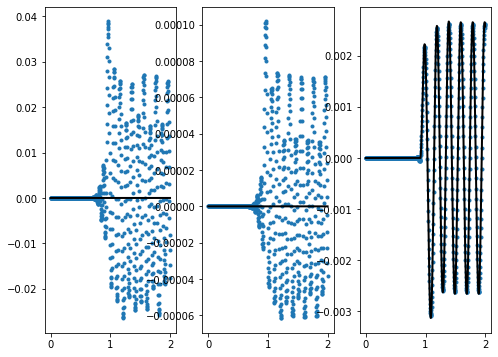

In [ ]:
# Resolve velocity components from numerical
theta_actual = np.arctan2(x_in[1], x_in[0])
u_vec = np.stack((vec_u, vec_v), axis=-1)
n_hat = x_in/np.linalg.norm(x_in)
u_r = np.einsum("ki, i -> k", u_vec, n_hat)[...,np.newaxis]
# Tangential velocity vector
u_t_vec = u_vec - (u_r * n_hat)
# Tangential unit vector in the positive angle direction
t_hat = np.einsum("ij, j -> i", np.array([[0, -1],[1, 0]]), n_hat)
# Compute u_theta
u_theta = np.einsum("ij, j -> i", u_t_vec, t_hat)

# Plot analytic solution
r = np.linalg.norm(x_in)
theta_rotated = np.arctan2(x_in[1], x_in[0]) + np.pi/2 # Rotate to +y initial movement
vec_t_high_sample = np.linspace(vec_t[0], vec_t[-1], 5*vec_t.size)
p_analytical, u_r_analytical, u_theta_analytical = field(r, theta_rotated, vec_t_high_sample)

fig, ax= plt.subplots(1, 3, figsize=(8,6))

ax[0].plot(vec_t, vec_p, '.')
ax[0].plot(vec_t_high_sample, p_analytical, 'k', linewidth=2)
ax[1].plot(vec_t, u_r, '.')
ax[1].plot(vec_t_high_sample, u_r_analytical, 'k', linewidth=2)
ax[2].plot(vec_t, u_theta, '.')
ax[2].plot(vec_t_high_sample, u_theta_analytical, 'k', linewidth=2)

### Convergence test

In [20]:
# Set global frequency for `field` function
w = 2 * (2 * np.pi)

In [730]:
# Define comparison function
def compare_at_qpoints(U, t, solver):
  # Compute state at quadrature points
  Uq = np.einsum("ij, kjl -> kil", solver.elem_helpers.basis_val, U)
  # Evaluate pressure at quadrature points
  pq = solver.physics.compute_variable("Pressure", Uq) - 1e5
  # Get quadrature points (in physical coordinates) with shape (ne, nq, 2)
  xq = solver.elem_helpers.x_elems
  rq = np.linalg.norm(xq, axis=-1, keepdims=True)
  thetaq = np.arctan2(xq[...,1:2], xq[...,0:1])
  # Velocity computation
  rho = Uq[:,:,0:3].sum(axis=-1, keepdims=True)
  vel = Uq[:,:,3:5] / rho
  nhat = solver.elem_helpers.x_elems / np.linalg.norm(solver.elem_helpers.x_elems, axis=-1, keepdims=True)
  that = np.einsum("ijk, mk -> ijm", nhat, np.array([[0, -1,],[1, 0]]))
  urq = np.einsum("ijk, ijk -> ij",
    vel,
    nhat)[:,:,np.newaxis]
  utq = np.einsum("ijk, ijk -> ij",
    vel,
    that)[:,:,np.newaxis]
  # Get integration weights (nq, 1)
  wq = solver.elem_helpers.quad_wts
  # Map analytic solution over rq, thetaq, time t
  pq_analytic, urq_analytic, utq_analytic = field(rq, thetaq + np.pi/2, t)
  # Report shapes
  rp_analytic = rq * pq_analytic
  rp = rq * pq
  # L2 error
  # ep_L2 = np.sqrt(np.einsum("ijk, ijk, ijk, jk ->",
  #                 rq * (pq_analytic - pq),
  #                 rq * (pq_analytic - pq),
  #                 solver.elem_helpers.djac_elems,
  #                 wq)) / (2 * 1000**3 / 3) # Half-ball scaling (ball volume divided by 2pi)
  # L2 error (Cartesian integration)
  ep_L2 = np.sqrt(np.einsum("ijk, ijk, ijk, jk ->",
                  (pq_analytic - pq),
                  (pq_analytic - pq),
                  solver.elem_helpers.djac_elems,
                  wq)) / (np.pi / 2 * 1000**2) # Half-disk scaling (sphere volume divided by 2pi)
  # L2 error (Cartesian integration)
  # ep_L2 = np.sqrt(np.einsum("ijk, ijk, ijk, jk ->",
  #                 xq[...,0:1] * (utq_analytic - utq),
  #                 xq[...,0:1] * (utq_analytic - utq),
  #                 solver.elem_helpers.djac_elems,
  #                 wq)) / (np.pi / 2 * 1000**2) # Half-disk scaling (sphere volume divided by 2pi)
  return xq, rq, thetaq, pq, rp, pq_analytic, rp_analytic, ep_L2, urq, utq, urq_analytic, utq_analytic

In [731]:
# Dict containing the scaled L2 error and true h of mesh
errs_L2_h = dict()

t = 5.999999999999965 s
t = 5.999999999999981 s
t = 6.000000000000084 s
t = 5.999999999999834 s
t = 5.999999999999943 s
t = 6.000000000000186 s
t = 6.000000000000561 s


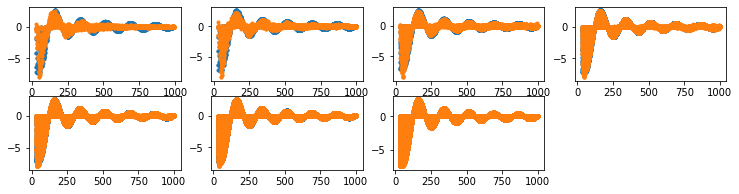

In [733]:
def compute_and_plot_errs(file_out_radix, load_index):
  npz_load = lambda i: np.load(f"{file_out_radix}{i}.npz")
  solver_from = lambda file_idx: readwritedatafiles.read_data_file(
    f"{file_out_radix}{file_idx}.pkl")

  solver = solver_from(0)
  dat_frame = npz_load(load_index)
  U = dat_frame["state_coeffs"]
  t = dat_frame["time"]
  print(f"t = {t} s")

  xq, rq, thetaq, pq, rp, pq_analytic, rp_analytic, ep_L2, urq, utq, urq_analytic, utq_analytic = compare_at_qpoints(U, t, solver)

  # plt.plot(rq.ravel(), pq_analytic.ravel(), '.')
  # plt.plot(rq.ravel(), pq.ravel(), '.')
  # plt.plot(rq.ravel(), urq_analytic.ravel(), '.')
  # plt.plot(rq.ravel(), urq.ravel(), '.')
  plt.plot(rq.ravel(), xq[...,0:1].ravel() * utq_analytic.ravel(), '.')
  plt.plot(rq.ravel(), xq[...,0:1].ravel() * utq.ravel(), '.')

  x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
  hmax = np.linalg.norm(np.stack((x_tri[:,1,:] - x_tri[:,0,:],
    x_tri[:,2,:] - x_tri[:,1,:],
    x_tri[:,0,:] - x_tri[:,2,:]), axis=1), axis=-1).max()

  return (ep_L2, hmax)

plt.figure(figsize=(12.5, 3))
plt.subplot(2,4,1)
errs_L2_h[120] = compute_and_plot_errs("sphere_h120p1_", 2)
plt.subplot(2,4,2)
errs_L2_h[85] = compute_and_plot_errs("sphere_h85p1_", 6)
plt.subplot(2,4,3)
errs_L2_h[51] = compute_and_plot_errs("sphere_h51p1_", 10)
plt.subplot(2,4,4)
errs_L2_h[34] = compute_and_plot_errs("sphere_h34p1_", 18)
plt.subplot(2,4,5)
errs_L2_h[24] = compute_and_plot_errs("sphere_h24p1_", 8)
plt.subplot(2,4,6)
errs_L2_h[17] = compute_and_plot_errs("sphere_h17p1_", 30)
plt.subplot(2,4,7)
errs_L2_h[8.5] = compute_and_plot_errs("sphere_h8p5p1_", 60)

In [725]:
npz_load = lambda i: np.load(f"sphere_h8p5p1_{i}.npz")
solver_from = lambda file_idx: readwritedatafiles.read_data_file(
  f"sphere_h8p5p1_{file_idx}.pkl")

solver = solver_from(0)
dat_frame = npz_load(60)
U = dat_frame["state_coeffs"]
t = dat_frame["time"]
print(f"t = {t} s")

xq, rq, thetaq, pq, rp, pq_analytic, rp_analytic, ep_L2, urq, utq, urq_analytic, utq_analytic = compare_at_qpoints(U, t, solver)

t = 6.000000000000561 s


t = 6.000000000000299 s
t = 6.000000000000124 s
t = 6.000000000000561 s
t = 6.00000000000075 s


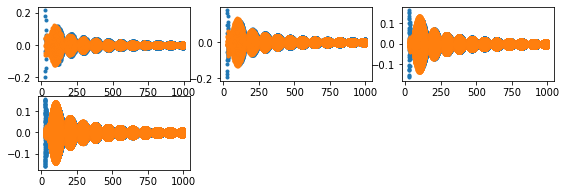

In [726]:
errs_L2_h_P2 = dict()

plt.figure(figsize=(12.5, 3))
plt.subplot(2,4,2)
errs_L2_h_P2[85] = compute_and_plot_errs("sphere_h85p2_", 24)
plt.subplot(2,4,3)
errs_L2_h_P2[51] = compute_and_plot_errs("sphere_h51p2_", 40)
plt.subplot(2,4,4)
errs_L2_h_P2[34] = compute_and_plot_errs("sphere_h34p2_", 72)
plt.subplot(2,4,6)
errs_L2_h_P2[17] = compute_and_plot_errs("sphere_h17p2_", 120)

In [727]:
wavelength0 = c / (w / (2*np.pi))
wavelength0

173.59435474692143

In [728]:
errs_L2_h

{120: (0.00025300411011114907, 147.88390449158553),
 85: (0.0002149496841855105, 107.5789500566859),
 51: (0.00013340701295256946, 67.56712519382023),
 34: (6.375293857802134e-05, 45.7716124424245),
 24: (3.9280759833180455e-05, 32.46797316735528),
 17: (2.0652529001024654e-05, 22.864729814613018),
 8.5: (7.063847439517264e-06, 11.540882368017874)}

Prod figure below

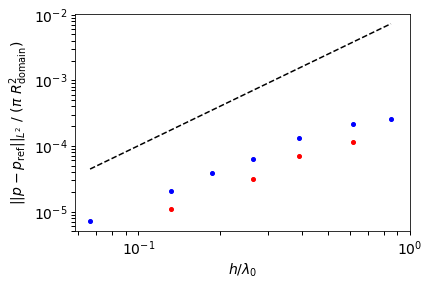

In [729]:
h_err_pairs = sorted(list(errs_L2_h.items()), key=lambda tup: tup[0])
vec_h_nominal, vec_data = zip(*h_err_pairs)
vec_err, vec_h = zip(*vec_data)
vec_h_nominal = np.array(vec_h_nominal)
vec_h = np.array(vec_h)
vec_err = np.array(vec_err)

fig, ax = plt.subplots(figsize=(6,4), dpi=200)
plt.loglog(vec_h / wavelength0, vec_err, 'b.', markersize=8)
# plt.loglog(vec_h, vec_h**1.5 / 1e7, 'k--')
# plt.loglog(vec_h, vec_h**1 / 2e9, 'k--')
# plt.loglog(vec_h, vec_h**2 / 1e9, 'k--')
plt.loglog(vec_h / wavelength0, vec_h**2 / 3e6, 'k--')
plt.xlabel(r"$\mathfrak{h} / \lambda_0$")
# plt.ylabel(r"$\frac{3}{2}~R_\mathrm{domain}^{-3}~|| p - p_\mathrm{ref} ||_{L^2}$")
plt.ylabel(r"$|| p - p_\mathrm{ref} ||_{L^2}~/~(\pi~r_\mathrm{domain}^{2} / 2)$")
plt.xlim(0.1, 1)
plt.ylim(1e-4, 1e-2)

h_err_pairs = sorted(list(errs_L2_h_P2.items()), key=lambda tup: tup[0])
vec_h_nominal, vec_data = zip(*h_err_pairs)
vec_err, vec_h = zip(*vec_data)
vec_h_nominal = np.array(vec_h_nominal)
vec_h = np.array(vec_h)
vec_err = np.array(vec_err)
plt.loglog(vec_h / wavelength0, vec_err, 'r.', markersize=8)


global_fontsize = 14
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(global_fontsize)
ax.tick_params('both', length=4, width=1, which='major')
ax.tick_params('both', length=4, width=1, which='minor')
ax.set_xticks([1e-1, 1e0])
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.plot(np.array([.4, .5]), np.array([.4, .5])**2 * 3e-3, 'k')
plt.plot(np.array([.4, .5]), np.array([.4, .4])**2 * 3e-3, 'k')
plt.plot(np.array([.5, .5]), np.array([.4, .5])**2 * 3e-3, 'k')

plt.text(.515, .42**2 * 3e-3, "2", fontsize=12)
plt.text(.438, .34**2 * 3e-3, "1", fontsize=12)

plt.savefig("sphere_l2_convergence.svg")
plt.savefig("sphere_l2_convergence.png")
plt.savefig("sphere_l2_convergence.pdf")

### Temp stuff below

In [ ]:
total_gas_volfrac = 1 - solver.physics.compute_variable("volFracM", solver.state_coeffs)
total_gas_volfrac.min()

1.0

In [ ]:
file_out_radix = "sphere_h51_"
npz_load = lambda i: np.load(f"{file_out_radix}{i}.npz")
solver_from = lambda file_idx: readwritedatafiles.read_data_file(
  f"{file_out_radix}{file_idx}.pkl")
npz_load(5)["time"]

array(3.000000000000015)

In [ ]:
# file_out_radix = "sphere_h34_"
# npz_load = lambda i: np.load(f"{file_out_radix}{i}.npz")
# solver_from = lambda file_idx: readwritedatafiles.read_data_file(
#   f"{file_out_radix}{file_idx}.pkl")
# npz_load()["time"]

In [ ]:
file_out_radix = "sphere_h17_"
npz_load = lambda i: np.load(f"{file_out_radix}{i}.npz")
solver_from = lambda file_idx: readwritedatafiles.read_data_file(
  f"{file_out_radix}{file_idx}.pkl")
npz_load(15)["time"]

array(2.999999999999917)

In [ ]:
# file_out_radix = "sphere_h8p5_"
# npz_load = lambda i: np.load(f"{file_out_radix}{i}.npz")
# solver_from = lambda file_idx: readwritedatafiles.read_data_file(
#   f"{file_out_radix}{file_idx}.pkl")
# npz_load(30)["time"]

Text(0.5, 1.0, '$\\Delta p \\cdot r$ (Pa $\\cdot$ m)')

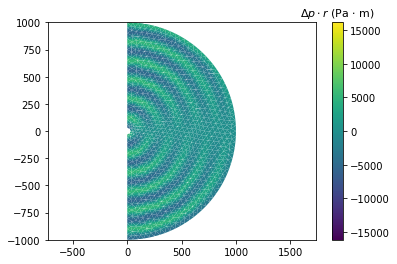

In [ ]:
# Set contour plot parameters
solver = solver_from(0)
frame_data = npz_load(5)

quantity = lambda U: solver.physics.compute_variable("Pressure", U) - 1e5
colorbar_label = "$\Delta p \cdot r$ (Pa $\cdot$ m)"
cmap = matplotlib.cm.viridis
# Set coordinate scaling to apply to plot values
coordinate_scaling = lambda x: np.linalg.norm(x, axis=-1, keepdims=True)

clims = (-16167, 16167)
x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
r_window = 1200

# Plot numeric solution field
plt.figure()
(_, cb) = processing.mdtools.plot_detailed(x_tri, frame_data["state_coeffs"],
  quantity, clims, 2,
  colorbar_label="",
  xview=(0,r_window),
  yview=(-r_window,r_window),
  n_samples=4,
  cmap=cmap,
  coordinate_scaling=coordinate_scaling)
cb.ax.set_title(colorbar_label, size=11)